In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# Define Paths
max_per_class = 10000
dataset_dir = "/kaggle/input/imagesoasis/Data"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Initialize empty lists to store image paths and labels
image_paths, labels = [], []

# Iterate over the classes to collect image paths
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = os.listdir(class_dir)
    # Sort the files and select up to `max_per_class` images
    files = sorted(files)[:max_per_class] if len(files) > max_per_class else files
    
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    
    # Add full file paths to image_paths list
    for file_name in files:
        full_path = os.path.join(class_dir, file_name)
        image_paths.append(full_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

# For debugging, print the first few paths
print(image_paths[:5])
print(labels[:5])


Class: Mild Dementia, Files Found: 5002
Class: Moderate Dementia, Files Found: 488
Class: Non Demented, Files Found: 10000
Class: Very mild Dementia, Files Found: 10000
['/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0185_MR1_mpr-1_145.jpg', '/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0269_MR1_mpr-2_128.jpg', '/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0316_MR1_mpr-2_127.jpg', '/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0053_MR1_mpr-2_107.jpg', '/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0382_MR1_mpr-1_154.jpg']
[0, 0, 0, 0, 0]


In [6]:
# Split Dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Total images: {len(image_paths)}")
print(f"Training images: {len(train_paths)}, Testing images: {len(test_paths)}")

Total images: 25490
Training images: 20392, Testing images: 5098


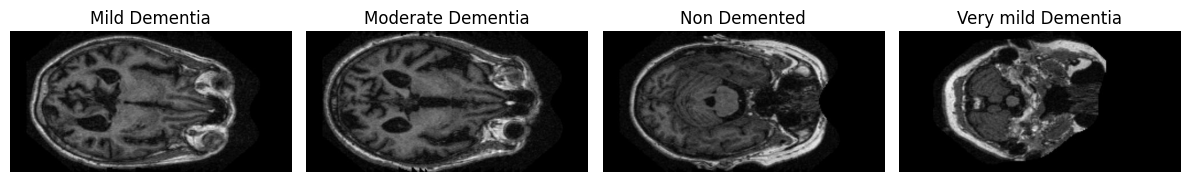

In [9]:
# Base directory where the dataset is located
root_dir = "/kaggle/input/imagesoasis/Data"  # Adjust as per your setup

# Create a mapping to store the first image per class
displayed_classes = set()

plt.figure(figsize=(12, 8))
img_shown = 0

# Loop through images and labels, displaying the first image from each class
for img_path, label in zip(image_paths, labels):
    class_name = classes[label]
    
    # Construct the full file path using the root_dir and class folder
    full_img_path = os.path.join(root_dir, class_name, img_path)  # img_path is just the file name
    
    # Check if the file exists
    if os.path.exists(full_img_path):
        if class_name not in displayed_classes:
            try:
                # Open and display the image
                image = Image.open(full_img_path)
                plt.subplot(1, 4, img_shown + 1)
                plt.imshow(image, cmap='gray')
                plt.title(class_name)
                plt.axis('off')
                displayed_classes.add(class_name)
                img_shown += 1

                # Stop if we've displayed images for all four classes
                if img_shown == 4:
                    break
            except Exception as e:
                print(f"Error loading image {full_img_path}: {e}")
    else:
        print(f"Warning: File not found at {full_img_path}, skipping.")

plt.tight_layout()
plt.show()


In [20]:
def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for classification tasks.
    Parameters:
    gamma: focusing parameter (default is 2)
    alpha: balance factor (default is 0.25)
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        
        # Clip predictions to prevent log(0) errors
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        # Calculate Cross Entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Focal loss calculation
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        
        return tf.reduce_sum(loss, axis=-1)
    
    return focal_loss_fixed


In [25]:
from tensorflow.keras.metrics import Precision, Recall

In [75]:
# from tensorflow.keras import layers, models
# from tensorflow.keras.metrics import Precision, Recall

# def conv_block(x, filters):
#     x = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)  # Smaller kernel
#     x = layers.MaxPooling2D(pool_size=2)(x)  # Max pooling instead of average pooling
#     return x

# def dense_block(x, units):
#     x = layers.Dense(units, activation='relu')(x)  # Activation directly inside Dense
#     return x

# def build_model(input_shape=(224, 224, 3), num_classes=4):
#     inputs = layers.Input(shape=input_shape)

#     # Feature Extraction Module
#     x = conv_block(inputs, 16)
#     x = conv_block(x, 32)
#     x = conv_block(x, 64)

#     # Flatten and Classification Module
#     x = layers.Flatten()(x)
#     x = dense_block(x, 128)  # Hidden dense block (size can be tuned)
#     x = layers.Dropout(0.3)(x)  # Increase dropout for regularization
#     x = layers.Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class output

#     model = models.Model(inputs, x)

#     return model

# # Build and compile the model
# model = build_model()

# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy', Precision(), Recall()]
# )

# model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,446,756 (24.59 MB)

 Trainable params: 6,446,756 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, kernel_size=5, padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    return x

def channel_attention(x):
    input_channels = x.shape[-1]
    gap = layers.GlobalAveragePooling2D()(x)
    dense1 = layers.Dense(input_channels // 4, activation='relu')(gap)
    dense2 = layers.Dense(input_channels, activation='sigmoid')(dense1)
    scale = layers.Multiply()([x, layers.Reshape((1, 1, input_channels))(dense2)])
    return scale

def dense_block(x, units):
    x = layers.Dense(units)(x)
    x = layers.ReLU()(x)
    return x

def build_model(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Feature Extraction Module
    x = conv_block(inputs, 16)
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)

    # Channel Attention
    x = channel_attention(x)

    # Flatten and Classification Module
    x = layers.Dropout(0.01)(x)
    x = layers.Flatten()(x)
    x = dense_block(x, 128)  # Hidden dense block (size can be tuned)
    x = layers.Dropout(0.03)(x)
    x = layers.Dense(4)(x)
    outputs = layers.Softmax()(x)

    model = models.Model(inputs, outputs)
    return model

# Build and compile the model
model = build_model()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
    ]
)
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 224, 224, 16)   │          1,216 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_36 (ReLU)           │ (None, 224, 224, 16)   │              0 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_30      │ (None, 112, 112, 16)   │              0 │ re_lu_36[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 112, 112, 32)   │         12,832 │ average_pooling2d_30[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_37 (ReLU)           │ (None, 112, 112, 32)   │              0 │ conv2d_31[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_31      │ (None, 56, 56, 32)     │              0 │ re_lu_37[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 56, 56, 64)     │         51,264 │ average_pooling2d_31[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_38 (ReLU)           │ (None, 56, 56, 64)     │              0 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_32      │ (None, 28, 28, 64)     │              0 │ re_lu_38[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 28, 28, 128)    │        204,928 │ average_pooling2d_32[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_39 (ReLU)           │ (None, 28, 28, 128)    │              0 │ conv2d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_33      │ (None, 14, 14, 128)    │              0 │ re_lu_39[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 14, 14, 256)    │        819,456 │ average_pooling2d_33[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_40 (ReLU)           │ (None, 14, 14, 256)    │              0 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_34      │ (None, 7, 7, 256)      │              0 │ re_lu_40[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_poolin

 Total params: 2,729,060 (10.41 MB)

 Trainable params: 2,729,060 (10.41 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# Normalize image paths and labels
train_paths = np.array(train_paths)
test_paths = np.array(test_paths)

# One-hot encode the labels for model training
label_binarizer = LabelBinarizer()
train_labels_onehot = label_binarizer.fit_transform(train_labels)
test_labels_onehot = label_binarizer.transform(test_labels)

# Use the integer labels directly for class_weight calculation
train_labels_int = label_binarizer.transform(train_labels).argmax(axis=1)  # This gives integer-encoded labels, not one-hot

# Define image loading and preprocessing functions
IMG_HEIGHT, IMG_WIDTH = 224, 224

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    return image

def load_dataset(image_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = path_ds.map(lambda path: preprocess_image(path), num_parallel_calls=tf.data.AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((image_ds, label_ds))

# Build train and test datasets
BATCH_SIZE = 32
train_dataset = load_dataset(train_paths, train_labels_onehot).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = load_dataset(test_paths, test_labels_onehot).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Get the classes from the label binarizer
classes = np.arange(len(label_binarizer.classes_))

# Compute class weights using the integer labels
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels_int)

# Map class indices (0, 1, 2, 3) to computed weights
class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}

# Print for sanity check
print("Class weights:", class_weight_dict)
for i, label in enumerate(label_binarizer.classes_):
    print(f"{i}: {label}")


Class weights: {0: 1.273863068465767, 1: 13.071794871794872, 2: 0.63725, 3: 0.63725}
0: 0
1: 1
2: 2
3: 3


In [47]:
from collections import Counter

In [49]:
# Print class distribution
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_dist = dict(Counter(train_labels))
test_dist = dict(Counter(test_labels))

print(f"Training labels distribution: {train_dist}")
print(f"Test labels distribution: {test_dist}")

Training labels distribution: {2: 8000, 3: 8000, 0: 4002, 1: 390}
Test labels distribution: {0: 1000, 2: 2000, 3: 2000, 1: 98}


In [40]:
# Get the mapping back from one-hot to label indices
class_names = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Show first 10 image paths and their decoded labels
for i in range(10):
    file_path = train_paths[i]
    label_vector = train_labels[i]
    class_index = np.argmax(label_vector)
    label_name = class_names[class_index]
    print(f"Path: {file_path}, Label: {label_name}")


Path: /kaggle/input/imagesoasis/Data/Non Demented/OAS1_0019_MR1_mpr-4_145.jpg, Label: Non Demented
Path: /kaggle/input/imagesoasis/Data/Non Demented/OAS1_0017_MR1_mpr-3_109.jpg, Label: Non Demented
Path: /kaggle/input/imagesoasis/Data/Very mild Dementia/OAS1_0021_MR1_mpr-4_112.jpg, Label: Very mild Dementia
Path: /kaggle/input/imagesoasis/Data/Non Demented/OAS1_0013_MR1_mpr-4_123.jpg, Label: Non Demented
Path: /kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0067_MR1_mpr-1_139.jpg, Label: Mild Dementia
Path: /kaggle/input/imagesoasis/Data/Very mild Dementia/OAS1_0205_MR1_mpr-2_155.jpg, Label: Very mild Dementia
Path: /kaggle/input/imagesoasis/Data/Non Demented/OAS1_0055_MR1_mpr-1_122.jpg, Label: Non Demented
Path: /kaggle/input/imagesoasis/Data/Very mild Dementia/OAS1_0115_MR1_mpr-1_103.jpg, Label: Very mild Dementia
Path: /kaggle/input/imagesoasis/Data/Very mild Dementia/OAS1_0273_MR1_mpr-1_105.jpg, Label: Very mild Dementia
Path: /kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_003

In [29]:
import os

# Check if image paths are valid
invalid_paths = [path for path in train_paths if not os.path.exists(path)]
if invalid_paths:
    print(f"Invalid image paths: {invalid_paths}")
else:
    print("All image paths are valid.")

All image paths are valid.


In [76]:
EPOCHS = 30
# BATCH_SIZE = 32

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True, 
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'sota_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

# Fit the model with callbacks
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, model_checkpoint],
    class_weight=class_weight_dict,
    verbose=2
)


Epoch 1/30

Epoch 1: val_loss improved from inf to 0.06615, saving model to sota_model.keras
638/638 - 41s - 64ms/step - accuracy: 0.6871 - loss: 0.6376 - precision: 0.8342 - recall: 0.5674 - val_accuracy: 0.9829 - val_loss: 0.0661 - val_precision: 0.9848 - val_recall: 0.9804
Epoch 2/30

Epoch 2: val_loss improved from 0.06615 to 0.01253, saving model to sota_model.keras
638/638 - 29s - 45ms/step - accuracy: 0.9539 - loss: 0.0976 - precision: 0.9587 - recall: 0.9487 - val_accuracy: 0.9973 - val_loss: 0.0125 - val_precision: 0.9973 - val_recall: 0.9973
Epoch 3/30

Epoch 3: val_loss did not improve from 0.01253
638/638 - 23s - 36ms/step - accuracy: 0.9721 - loss: 0.0625 - precision: 0.9750 - recall: 0.9702 - val_accuracy: 0.9965 - val_loss: 0.0154 - val_precision: 0.9967 - val_recall: 0.9959
Epoch 4/30

Epoch 4: val_loss improved from 0.01253 to 0.00231, saving model to sota_model.keras
638/638 - 23s - 36ms/step - accuracy: 0.9853 - loss: 0.0275 - precision: 0.9865 - recall: 0.9846 - val

KeyboardInterrupt: 

160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


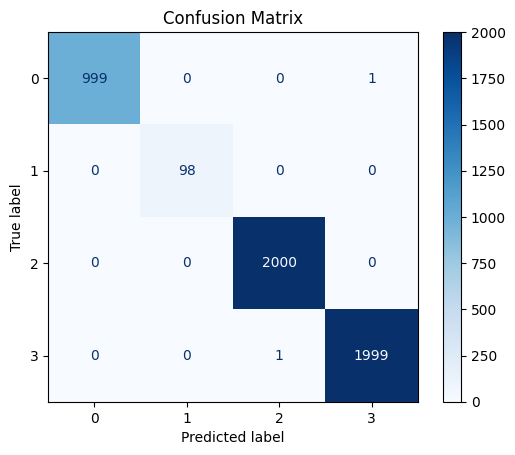

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from the test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)  # Convert from one-hot to label

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


638/638 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step


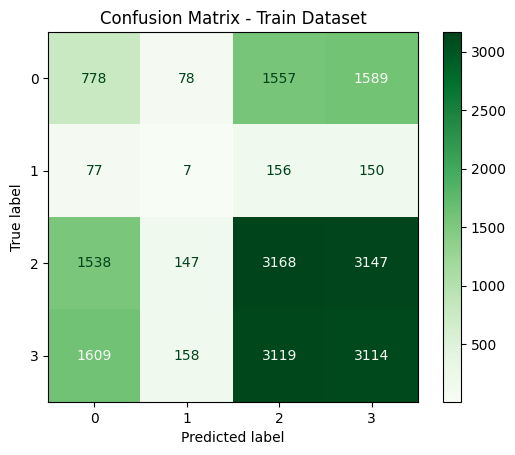

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predictions on the training dataset
y_train_probs = model.predict(train_dataset)
y_train_pred = np.argmax(y_train_probs, axis=1)

# Get true labels from the train dataset
y_train_true = np.concatenate([y for x, y in train_dataset], axis=0)
y_train_true = np.argmax(y_train_true, axis=1)

# Compute confusion matrix
cm_train = confusion_matrix(y_train_true, y_train_pred)

# Plot confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=classes)
disp_train.plot(cmap='Greens')
plt.title("Confusion Matrix - Train Dataset")
plt.show()
